Crear set de datos

In [ ]:
import pandas as pd

# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')

# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstracts_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type': 'entity_1_type'}, inplace=True)

# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)

# Revisar las columnas después de las fusiones para identificar los nombres correctos
print("Columnas disponibles después de la fusión:", merged_df.columns)


# Verificar el DataFrame de entrenamiento
print(merged_df.head())

# Guardar el DataFrame en un archivo CSV para futuros usos



Columnas disponibles después de la fusión: Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids_x', 'entity_1_mention', 'type_y',
       'entity_ids_y', 'entity_2_mention', 'entity_2_type'],
      dtype='object')
   id abstract_id       type_x entity_1_id entity_2_id novel  \
0   0     1353340  Association         410     D007966    No   
1   0     1353340  Association         410     D007966    No   
2   0     1353340  Association         410     D007966    No   
3   0     1353340  Association         410     D007966    No   
4   0     1353340  Association         410     D007966    No   

                                            abstract  \
0  We report on a new allele at the arylsulfatase...   
1  We report on a new allele at the arylsulfatase...   
2  We report on a new allele at the arylsulfatase...   
3  We report on a new allele at the arylsulfatase...   
4  We report on a new allele at the arylsulfatase...   

 

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73910 entries, 0 to 73909
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                73910 non-null  int64 
 1   abstract_id       73910 non-null  object
 2   type_x            73910 non-null  object
 3   entity_1_id       73910 non-null  object
 4   entity_2_id       73910 non-null  object
 5   novel             73910 non-null  object
 6   abstract          73910 non-null  object
 7   title             73910 non-null  object
 8   entity_ids_x      73910 non-null  object
 9   entity_1_mention  73910 non-null  object
 10  type_y            73910 non-null  object
 11  entity_ids_y      73910 non-null  object
 12  entity_2_mention  73910 non-null  object
 13  entity_2_type     73910 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.9+ MB


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Asumiendo que merged_df ya está creado y contiene las columnas 'abstract' y 'type_x' (que es la relación)

# 1. Convertir los abstracts a minúsculas
merged_df['abstract'] = merged_df['abstract'].str.lower()

# Verificar que se haya hecho la conversión a minúsculas
print("Abstracts en minúsculas:\n", merged_df['abstract'].head())

# 2. Tokenización y Padding

# Parámetros de tokenización
max_words = 10000  # Número máximo de palabras a mantener en el vocabulario
max_len = 100  # Longitud máxima de las secuencias (después del padding)

# Crear el tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  # OOV es para palabras fuera del vocabulario
tokenizer.fit_on_texts(merged_df['abstract'])

# Convertir los abstracts a secuencias de tokens
sequences = tokenizer.texts_to_sequences(merged_df['abstract'])

# Aplicar padding a las secuencias para que todas tengan la misma longitud
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Verificar las primeras secuencias tokenizadas y con padding
print("Primeras secuencias tokenizadas y con padding:\n", padded_sequences[:5])

# 3. Preparar las etiquetas (Relation Type)
# Convertir las relaciones en etiquetas numéricas usando LabelEncoder
label_encoder = LabelEncoder()
merged_df['type_x'] = label_encoder.fit_transform(merged_df['type_x'])

# Verificar las etiquetas convertidas
print("Etiquetas de relación convertidas a números:\n", merged_df['type_x'].head())

# Ahora tienes `padded_sequences` (que es la entrada para el modelo) y las etiquetas numéricas `merged_df['type_x']`

# Verificación final
print("Tamaño del conjunto de secuencias con padding:", padded_sequences.shape)
print("Tamaño del conjunto de etiquetas:", merged_df['type_x'].shape)


Abstracts en minúsculas:
 0    we report on a new allele at the arylsulfatase...
1    we report on a new allele at the arylsulfatase...
2    we report on a new allele at the arylsulfatase...
3    we report on a new allele at the arylsulfatase...
4    we report on a new allele at the arylsulfatase...
Name: abstract, dtype: object
Primeras secuencias tokenizadas y con padding:
 [[  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11  129 8376    7 1498   11   15  686 2694
     5    2 8097   29  183   15 6039   13 1562    5  490    8  786   11
   455  766  475 6886    2 8376    8 1562  299   15   33    6  501 4538
  6885   82    7 1002    4  841 6885  526    3  169  133   24   42  339
  1078    2  129    4 3054   20    6 6886  252  227 9349    2 7691   11
   267 5027    4 4538 6885   82   44    2 1262    4 7506 1050    5 6886
     0    0]
 [  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11 

LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario (debe coincidir con el tokenizer)
embedding_dim = 64  # Dimensionalidad del espacio de embedding
max_len = 100  # Longitud máxima de las secuencias (después del padding)

# Construir el modelo secuencial
model = Sequential()

# 1. Capa de Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# 2. Capa LSTM
model.add(LSTM(64, return_sequences=False))

# 3. Capa de Dropout para evitar sobreajuste
model.add(Dropout(0.5))

# 4. Capa final de clasificación (Dense)
# Ajusta el número de neuronas en la última capa según el número de clases que tengas (número de relaciones)
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 124s 65ms/step - accuracy: 0.5883 - loss: 1.0069 - val_accuracy: 0.4284 - val_loss: 1.2592
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 120s 65ms/step - accuracy: 0.6601 - loss: 0.7557 - val_accuracy: 0.4836 - val_loss: 1.2104
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 119s 64ms/step - accuracy: 0.6631 - loss: 0.7380 - val_accuracy: 0.4279 - val_loss: 1.2303
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 142s 64ms/step - accuracy: 0.6691 - loss: 0.7250 - val_accuracy: 0.4154 - val_loss: 1.3067
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 141s 64ms/step - accuracy: 0.6686 - loss: 0.7220 - val_accuracy: 0.3813 - val_loss: 1.2824
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 143s 64ms/step - accuracy: 0.6746 - loss: 0.7111 - val_accuracy: 0.4185 - val_loss: 1.2658
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 141s 64ms/step - accuracy: 0.6709 - loss: 0.7143 - val_accuracy: 0.4488 - val_loss: 1.2735
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 143s 65ms/step - accuracy: 

In [ ]:
# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


2310/2310 - 33s - 14ms/step - accuracy: 0.6226 - loss: 0.8099
Loss: 0.8098706603050232
Accuracy: 0.6225680112838745


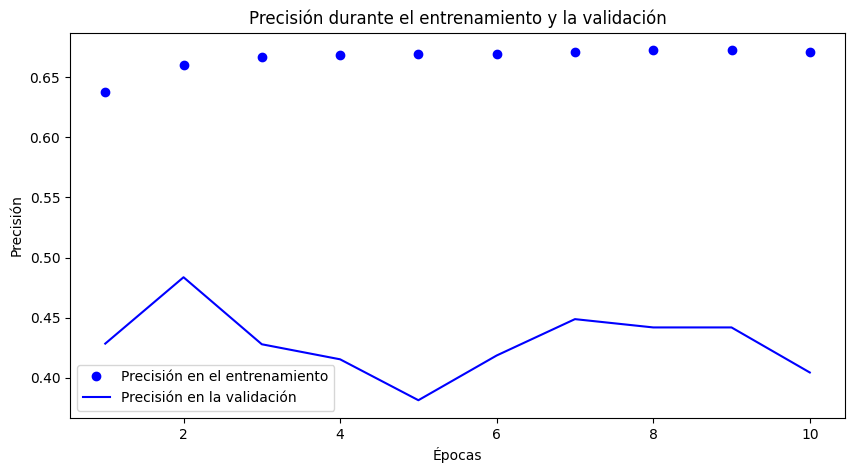

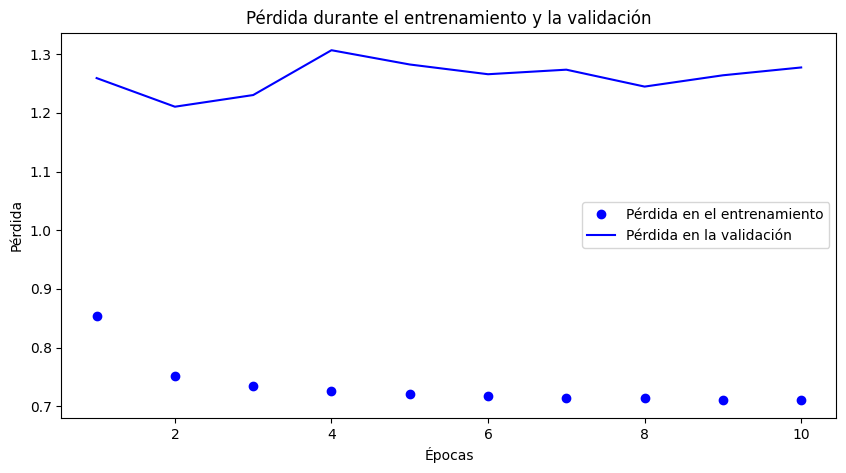

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Graficar la precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión en la validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en la validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 64  # Dimensión del embedding
max_len = 100  # Longitud máxima de las secuencias
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)

# Construir el modelo secuencial
model_rnn = Sequential()

# Capa de Embedding
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Capa Simple RNN
model_rnn.add(SimpleRNN(64, return_sequences=False))

# Capa de Dropout
model_rnn.add(Dropout(0.5))

# Capa densa de clasificación
model_rnn.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

# Entrenar el modelo
history_rnn = model_rnn.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - accuracy: 0.5976 - loss: 0.9732 - val_accuracy: 0.4948 - val_loss: 1.1100
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.6540 - loss: 0.7795 - val_accuracy: 0.5456 - val_loss: 1.0971
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.6490 - loss: 0.7709 - val_accuracy: 0.4958 - val_loss: 1.1245
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.6573 - loss: 0.7585 - val_accuracy: 0.4558 - val_loss: 1.1552
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6553 - loss: 0.7601 - val_accuracy: 0.4932 - val_loss: 1.1585
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6572 - loss: 0.7522 - val_accuracy: 0.4260 - val_loss: 1.1295
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6563 - loss: 0.7542 - val_accuracy: 0.4249 - val_loss: 1.1484
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.6581 -

In [ ]:
# Evaluar el modelo RNN en los datos de validación
loss_rnn, accuracy_rnn = model_rnn.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss (RNN): {loss_rnn}")
print(f"Accuracy (RNN): {accuracy_rnn}")


2310/2310 - 16s - 7ms/step - accuracy: 0.6326 - loss: 0.7970
Loss (RNN): 0.797034740447998
Accuracy (RNN): 0.6325801610946655


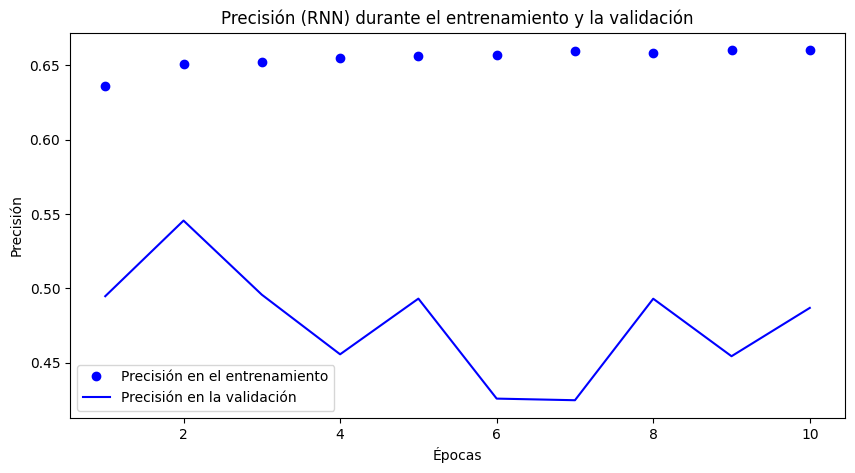

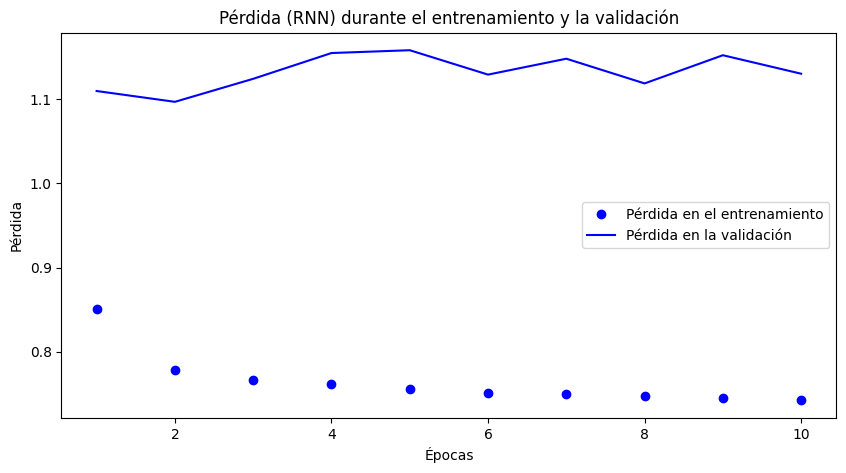

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento del RNN
history_dict_rnn = history_rnn.history
accuracy_rnn = history_dict_rnn['accuracy']
val_accuracy_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs = range(1, len(accuracy_rnn) + 1)

# Graficar la precisión (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_rnn, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy_rnn, 'b', label='Precisión en la validación')
plt.title('Precisión (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_rnn, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_rnn, 'b', label='Pérdida en la validación')
plt.title('Pérdida (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



In [ ]:
from transformers import TFAlbertForSequenceClassification, AlbertTokenizer

# Cargar el tokenizer y el modelo preentrenado de ALBERT
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)

# Preprocesar los textos
encoded_inputs = encode_texts(merged_df['abstract'], max_len=100)

# Compilar el modelo ALBERT
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
albert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_albert = albert_model.fit(
    {'input_ids': encoded_inputs['input_ids'], 'attention_mask': encoded_inputs['attention_mask']},
    merged_df['type_x'],
    epochs=3,
    batch_size=16,
    validation_split=0.2
)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7ea0c7423460>